In [311]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client as FDSN_Client
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import os
from scipy import signal
from math import pi 
from glob import glob
from progress.bar import Bar
from tqdm.notebook import tqdm


In [24]:
#load the full list of quakes (not all of these have spectra)
quakelist=pd.read_csv('data/quakelist1.txt',sep="|") 
quakelist.columns = quakelist.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

#load the full list of stations that we have data for (this will be curated later)
stationlist=pd.read_csv('data/station_h_data.txt',sep="|")
stationlist.columns = stationlist.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [25]:
quakelist

,eventid,time,latitude,longitude,depth/km,author,catalog,contributor,contributorid,magtype,magnitude,magauthor,eventlocationname
0,2016p868245,2016-11-17T06:01:10,-42.222,173.586,15.0,GNS,GNS,GNS,2016p868245,M,4.3,GNS,20 km north of Kaikoura
1,2016p890934,2016-11-25T15:25:47,-18.902,-175.432,183.0,GNS,GNS,GNS,2016p890934,M,4.1,GNS,2080 km north-east of Cape Reinga
2,2018p951534,2018-12-19T01:37:40,-36.140,-101.700,10.0,GNS,GNS,GNS,2018p951534,mB,6.1,GNS,6860 km south-east of Tolaga Bay
3,2016p971842,2016-12-25T13:57:38,-34.571,-178.637,33.0,GNS,GNS,GNS,2016p971842,Mw(mB),4.0,GNS,430 km north-east of Te Araroa
4,2016p934797,2016-12-11T20:57:54,-24.232,-179.541,467.0,GNS,GNS,GNS,2016p934797,M,5.1,GNS,1355 km north-east of Cape Reinga
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9235,2013p198520,2013-03-15T10:50:32,-31.618,-178.682,134.2,GNS,GNS,GNS,2013p198520,M,4.1,GNS,715 km north-east of Te Araroa
9236,2013p208507,2013-03-19T03:31:30,-32.756,-179.552,12.0,GNS,GNS,GNS,2013p208507,M,5.2,GNS,570 km north of Te Araroa
9237,2013p212396,2013-03-20T14:02:28,-22.065,-179.490,581.0,GNS,GNS,GNS,2013p212396,M,4.6,GNS,1565 km north-east of Cape Reinga
9238,2013p215643,2013-03-21T18:54:01,-31.687,-179.487,261.0,GNS,GNS,GNS,2013p215643,M,4.4,GNS,685 km north of Te Araroa


In [26]:
stationlist

,#network,station,latitude,longitude,elevation,sitename,starttime,endtime
0,NZ,APZ,-46.831806,167.988825,601.0,The Paps,2006-05-07T00:00:00,NaN
1,NZ,BFZ,-40.679647,176.246245,283.0,Birch Farm,1996-04-03T00:00:00,NaN
2,NZ,BHW,-41.408231,174.871115,101.0,Baring Head,1975-11-27T00:00:00,NaN
3,NZ,BKZ,-39.165666,176.492544,706.0,Black Stump Farm,2004-02-11T00:00:00,NaN
4,NZ,COVZ,-39.199914,175.542402,1133.0,Chateau Observatory,1998-03-25T00:00:00,NaN
...,...,...,...,...,...,...,...,...
69,NZ,WHZ,-45.892428,167.947031,345.0,Wether Hill Road,1993-03-22T00:00:00,NaN
70,NZ,WIZ,-37.524511,177.189302,40.0,White Island,1976-12-12T00:00:00,NaN
71,NZ,WKZ,-44.827021,169.017562,558.0,Wanaka,2004-06-03T00:00:00,NaN
72,NZ,WSRZ,-37.518110,177.177805,292.4,White Island Summit,2013-04-08T00:00:00,NaN


In [27]:
stationlist

,#network,station,latitude,longitude,elevation,sitename,starttime,endtime
0,NZ,APZ,-46.831806,167.988825,601.0,The Paps,2006-05-07T00:00:00,NaN
1,NZ,BFZ,-40.679647,176.246245,283.0,Birch Farm,1996-04-03T00:00:00,NaN
2,NZ,BHW,-41.408231,174.871115,101.0,Baring Head,1975-11-27T00:00:00,NaN
3,NZ,BKZ,-39.165666,176.492544,706.0,Black Stump Farm,2004-02-11T00:00:00,NaN
4,NZ,COVZ,-39.199914,175.542402,1133.0,Chateau Observatory,1998-03-25T00:00:00,NaN
...,...,...,...,...,...,...,...,...
69,NZ,WHZ,-45.892428,167.947031,345.0,Wether Hill Road,1993-03-22T00:00:00,NaN
70,NZ,WIZ,-37.524511,177.189302,40.0,White Island,1976-12-12T00:00:00,NaN
71,NZ,WKZ,-44.827021,169.017562,558.0,Wanaka,2004-06-03T00:00:00,NaN
72,NZ,WSRZ,-37.518110,177.177805,292.4,White Island Summit,2013-04-08T00:00:00,NaN


In [28]:
#when downloading quake data, we recorded whether the quake happened before a given station
with open('data/quake_before_station.pkl','rb') as f:
    quake_before_station= pickle.load(f)
#also recorded if saving the data failed for some other reason
#this is pretty bad probably because the internet died
with open('data/savefail.pkl','rb') as f:
    savefail= pickle.load(f)

In [29]:
quake_before_station

,quakeid,quaketime,stationid,stationstart
0,2016p650710,2016-08-28T18:14:07,HD63,2017-03-08T00:00:00
1,2016p650710,2016-08-28T18:14:07,HD64,2017-03-09T00:00:00
2,2016p650710,2016-08-28T18:14:07,HD65,2017-03-15T00:00:00
3,2016p605803,2016-08-12T03:29:28,HD63,2017-03-08T00:00:00
4,2016p605803,2016-08-12T03:29:28,HD64,2017-03-09T00:00:00
...,...,...,...,...
1819,2013p007717,2013-01-03T20:30:36,HD64,2017-03-09T00:00:00
1820,2013p007717,2013-01-03T20:30:36,HD65,2017-03-15T00:00:00
1821,2013p007717,2013-01-03T20:30:36,NTVZ,2014-11-06T00:00:00
1822,2013p007717,2013-01-03T20:30:36,TMVZ,2013-05-14T00:00:00


In [30]:
savefail

,quakeid,quaketime,stationid,stationstart
0,2019p349067,2019-05-10T03:43:18,HD61,2016-07-18T00:00:00
1,2019p349067,2019-05-10T03:43:18,HD62,2016-07-14T00:00:00
2,2019p349067,2019-05-10T03:43:18,HD63,2017-03-08T00:00:00
3,2019p349067,2019-05-10T03:43:18,HD64,2017-03-09T00:00:00
4,2019p349067,2019-05-10T03:43:18,HD65,2017-03-15T00:00:00
...,...,...,...,...
23162,2019p159579,2019-03-01T01:02:10,HD61,2016-07-18T00:00:00
23163,2019p159579,2019-03-01T01:02:10,HD62,2016-07-14T00:00:00
23164,2019p159579,2019-03-01T01:02:10,HD63,2017-03-08T00:00:00
23165,2019p159579,2019-03-01T01:02:10,HD64,2017-03-09T00:00:00


In [31]:
stationlist['n_quakes']=pd.Series(np.zeros(74),index=stationlist.index) #adding a column for the number of quakes recorded at this station during the time period

In [32]:
file_list1=os.listdir('data/2019p159579')
folderlist=glob('data/20*/')
folderlist
for foldername1 in folderlist: #for all the data folders (each quake)
    file_list1=os.listdir(foldername1) #for all files in folders (stations recording quakes)
    for filename1 in file_list1:
        #if the station recorded the quake, increase the n_quakes for that station 
        stationlist.loc[stationlist['station']==filename1[:-4],'n_quakes']=stationlist[stationlist['station']==filename1[:-4]]['n_quakes']+1

In [33]:
stationlist

,#network,station,latitude,longitude,elevation,sitename,starttime,endtime,n_quakes
0,NZ,APZ,-46.831806,167.988825,601.0,The Paps,2006-05-07T00:00:00,NaN,227.0
1,NZ,BFZ,-40.679647,176.246245,283.0,Birch Farm,1996-04-03T00:00:00,NaN,230.0
2,NZ,BHW,-41.408231,174.871115,101.0,Baring Head,1975-11-27T00:00:00,NaN,140.0
3,NZ,BKZ,-39.165666,176.492544,706.0,Black Stump Farm,2004-02-11T00:00:00,NaN,224.0
4,NZ,COVZ,-39.199914,175.542402,1133.0,Chateau Observatory,1998-03-25T00:00:00,NaN,231.0
...,...,...,...,...,...,...,...,...,...
69,NZ,WHZ,-45.892428,167.947031,345.0,Wether Hill Road,1993-03-22T00:00:00,NaN,230.0
70,NZ,WIZ,-37.524511,177.189302,40.0,White Island,1976-12-12T00:00:00,NaN,228.0
71,NZ,WKZ,-44.827021,169.017562,558.0,Wanaka,2004-06-03T00:00:00,NaN,228.0
72,NZ,WSRZ,-37.518110,177.177805,292.4,White Island Summit,2013-04-08T00:00:00,NaN,213.0


In [34]:
with open('data/2019p710345/APZ.pkl','rb') as f:
    st1= pickle.load(f)

In [35]:
tr1=st1[1]

In [36]:
st1[0].stats

               network: NZ
               station: APZ
              location: 10
               channel: HHE
             starttime: 2019-09-20T18:49:27.998394Z
               endtime: 2019-09-20T20:49:27.998394Z
         sampling_rate: 100.0
                 delta: 0.01
                  npts: 720001
                 calib: 1.0
_fdsnws_dataselect_url: http://service.geonet.org.nz/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1718, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 2595840})
            processing: ['ObsPy 1.2.1: trim(endtime=UTCDateTime(2019, 9, 20, 20, 49, 27, 998394)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2019, 9, 20, 18, 49, 27, 998394))']
              response: Channel Response
	From m/s () to count ()
	Overall Sensitivity: 8.38861e+08 defined at 1.000 Hz
	3 stages:
		Stage 1: PolesZerosResponseStage from m/s to V, gain: 

In [37]:
st1[1].stats.starttime,st1[1].stats.endtime

(2019-09-20T18:49:27.998394Z, 2019-09-20T20:49:27.998394Z)

In [38]:
st1[1].stats.starttime+st1[1].stats.npts/st1[1].stats.sampling_rate

2019-09-20T20:49:28.008394Z

In [39]:
st1

3 Trace(s) in Stream:
NZ.APZ.10.HHE | 2019-09-20T18:49:27.998394Z - 2019-09-20T20:49:27.998394Z | 100.0 Hz, 720001 samples
NZ.APZ.10.HHN | 2019-09-20T18:49:27.998394Z - 2019-09-20T20:49:27.998394Z | 100.0 Hz, 720001 samples
NZ.APZ.10.HHZ | 2019-09-20T18:49:27.998394Z - 2019-09-20T20:49:27.998394Z | 100.0 Hz, 720001 samples

In [40]:
tt=1/tr1.stats.sampling_rate*np.array(range(tr1.stats.npts))

In [41]:
# sig1=tr1.data
# widths=np.logspace(-4,2,num=301)
# cmtmatr=signal.cwt(sig1,signal.ricker,widths)
# plt.figure(figsize=(16,12))
# plt.imshow(abs(cmtmatr)**2, extent=[tt[0], tt[-1], widths[0]/2/pi,widths[-1]/2/pi], aspect='auto',)
# plt.yscale("log")
# plt.colorbar()

In [42]:
mid_ind=int((tr1.stats.npts-1)/2)
start_ind=mid_ind-50000
stop_ind=mid_ind+30000

tt1=tt[start_ind:stop_ind]
sig1=tr1.data[start_ind:stop_ind]

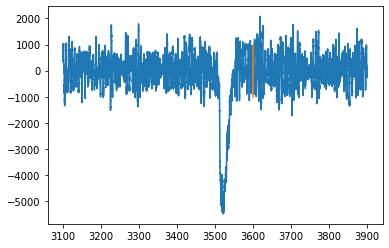

In [20]:
plt.plot(tt1,sig1)
plt.plot(tt[mid_ind]*np.ones(2),[1000,-1000])

In [43]:
tt[int((tr1.stats.npts-1)/2)]

3600.0

In [22]:
def wf_section(tr1,start_t,stop_t,tt):
    max_ind=np.argmax((np.abs(tr1.data-np.mean(tr1.data))))
    start_ind=max_ind+int(tr1.stats.sampling_rate*start_t)
    stop_ind=max_ind+int(tr1.stats.sampling_rate*stop_t)
    if start_ind<0:
        start_ind=0
        
    if stop_ind>len(tt):
        stop_ind=len(tt)
    
    tt_slice=tt[start_ind:stop_ind]
    wf_slice=tr1.data[start_ind:stop_ind]
    
    return wf_slice, tt_slice

In [23]:
wf_slice ,tt_slice= wf_section(tr1,-60*10,-60*8,tt)

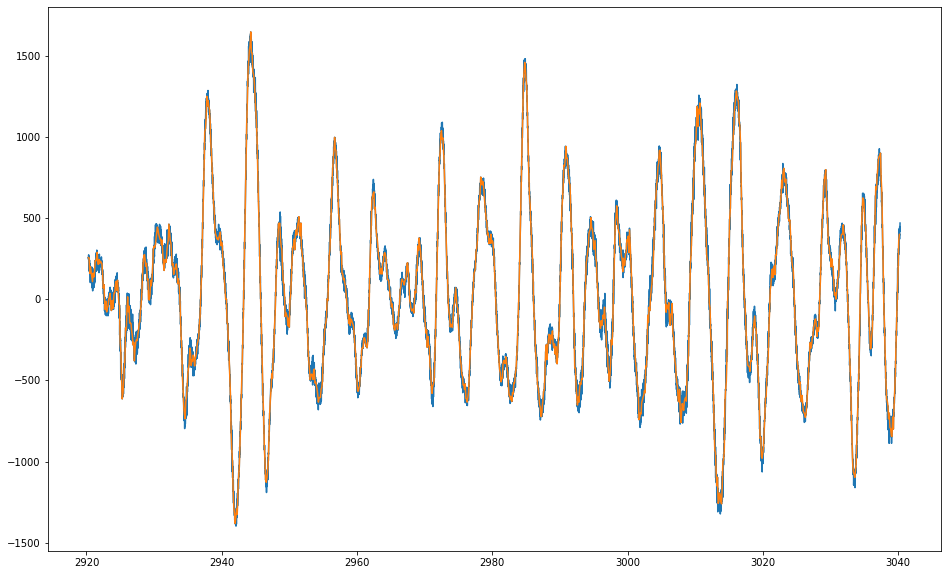

In [24]:
plt.figure(figsize=(16,10))
plt.plot(tt_slice,wf_slice)
step1=10
plt.plot(tt_slice[0:-1:step1],wf_slice[0:-1:step1])

# plt.plot(tt[mid_ind]*np.ones(2),[1000,-1000])

In [25]:
# sig1=tr1.data
# widths=np.logspace(-4,2,num=301)
# cmtmatr=signal.cwt(sig1,signal.ricker,widths)
# plt.figure(figsize=(16,12))
# plt.imshow(abs(cmtmatr)**2, extent=[tt[0], tt[-1], widths[0]/2/pi,widths[-1]/2/pi], aspect='auto',)
# plt.yscale("log")
# plt.colorbar()

In [66]:
help(np.floor)

Help on ufunc object:

floor = class ufunc(builtins.object)
 |  Functions that operate element by element on whole arrays.
 |  
 |  To see the documentation for a specific ufunc, use `info`.  For
 |  example, ``np.info(np.sin)``.  Because ufuncs are written in C
 |  (for speed) and linked into Python with NumPy's ufunc facility,
 |  Python's help() function finds this page whenever help() is called
 |  on a ufunc.
 |  
 |  A detailed explanation of ufuncs can be found in the docs for :ref:`ufuncs`.
 |  
 |  Calling ufuncs:
 |  ===============
 |  
 |  op(*x[, out], where=True, **kwargs)
 |  Apply `op` to the arguments `*x` elementwise, broadcasting the arguments.
 |  
 |  The broadcasting rules are:
 |  
 |  * Dimensions of length 1 may be prepended to either array.
 |  * Arrays may be repeated along dimensions of length 1.
 |  
 |  Parameters
 |  ----------
 |  *x : array_like
 |      Input arrays.
 |  out : ndarray, None, or tuple of ndarray and None, optional
 |      Alternate array

# Generating data

So we will start without the spectrogram and see if it works.

For each quake we will take make a 2D dataset, which will be a grid of the quake data over the requested time frame.
Initially we will look at data that starts between 10 and 15 minutes before a quake, and lasts for 5 minutes. e.g. $t_{start}=-15+rand*5$,  $t_{stop}=-10+rand*5$, these numbers can be adjusted tho. For example for the "is there an earthquake happening right now" test we will look at $t_{start}=-2$,  $t_{stop}=2$, where these times are all taken wrt the quake peak.

For dealing with all the stations we need to make sure that our times sync up, therefore we will use station which has the earliest peak as the time of the quake. 

In [26]:
file_list1=os.listdir('data/2019p159579')
folderlist=glob('data/20*/')
folderlist

['data/2013p480298/',
 'data/2013p488901/',
 'data/2012p866005/',
 'data/2013p803751/',
 'data/2012p986878/',
 'data/2017p145169/',
 'data/2017p662580/',
 'data/2018p375525/',
 'data/2019p024880/',
 'data/2019p484434/',
 'data/2013p215643/',
 'data/2019p660829/',
 'data/2014p891954/',
 'data/2016p882181/',
 'data/2014p471355/',
 'data/2016p858108/',
 'data/2014p347148/',
 'data/2016p074729/',
 'data/2019p710345/',
 'data/2018p903363/',
 'data/2014p132118/',
 'data/2020p050559/',
 'data/2016p862364/',
 'data/2019p589276/',
 'data/2016p724829/',
 'data/2016p069435/',
 'data/2019p078722/',
 'data/2013p498572/',
 'data/2014p708931/',
 'data/2013p544418/',
 'data/2014p124655/',
 'data/2016p648708/',
 'data/2016p876927/',
 'data/2015p765388/',
 'data/2017p295787/',
 'data/2015p687290/',
 'data/2017p539129/',
 'data/2016p114661/',
 'data/2016p858356/',
 'data/2019p556106/',
 'data/2013p141077/',
 'data/2019p008544/',
 'data/2019p028887/',
 'data/2015p109763/',
 'data/2019p174851/',
 'data/201

In [44]:
len(folderlist)

546

In [45]:
stations_over_min

NameError: name 'stations_over_min' is not defined

In [ ]:
l3=0
for foldername1 in folderlist:
    file_list1=os.listdir(foldername1)

    for filename1 in file_list1:
        with open(foldername1+filename1,'rb') as f:
            st1= pickle.load(f)
            if len(st1)==3:
                l3=l3+1
                for tr1 in st1:
                      if tr1.stats.sampling_rate!=100.0:
                        print(tr1)

In [ ]:
1+1

In [ ]:

stationlist[0:60]

In [ ]:
stationlist.size, quakelist.size

In [ ]:
stationlist[60:]

In [ ]:

for foldername1 in folderlist:
    file_list1=os.listdir(foldername1)
    for filename1 in file_list1:
        stationlist.loc[stationlist['station']==filename1[:-4],'n_quakes']=stationlist[stationlist['station']==filename1[:-4]]['n_quakes']+1

In [ ]:
folderna

In [36]:
sorted(n_quakes)

NameError: name 'n_quakes' is not defined

(array([  1.,   1.,   1.,   1.,   1.,   2.,   2.,   2.,   2.,   2.,   2.,
          2.,   2.,   2.,   2.,   6.,   6.,   6.,   6.,   6.,   8.,   8.,
          8.,   8.,   8.,  15.,  15.,  15.,  15.,  15.,  21.,  21.,  21.,
         21.,  21.,  34.,  34.,  34.,  34.,  34.,  42.,  42.,  42.,  42.,
         42.,  54.,  54.,  54.,  54.,  57.]),
 array([ 221. ,  221.2,  221.4,  221.6,  221.8,  222. ,  222.2,  222.4,
         222.6,  222.8,  223. ,  223.2,  223.4,  223.6,  223.8,  224. ,
         224.2,  224.4,  224.6,  224.8,  225. ,  225.2,  225.4,  225.6,
         225.8,  226. ,  226.2,  226.4,  226.6,  226.8,  227. ,  227.2,
         227.4,  227.6,  227.8,  228. ,  228.2,  228.4,  228.6,  228.8,
         229. ,  229.2,  229.4,  229.6,  229.8,  230. ,  230.2,  230.4,
         230.6,  230.8,  231. ]),
 <a list of 50 Patch objects>)

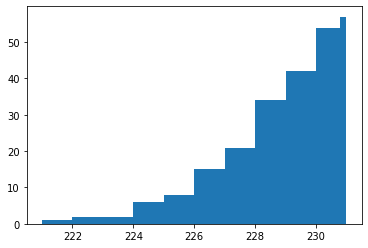

In [59]:
n_quakes=(stationlist['n_quakes'].to_numpy())
plt.hist(n_quakes[n_quakes>220],bins=50,cumulative=1)

In [38]:


for foldername1 in folderlist: #for all the data folders (each quake)
    file_list1=os.listdir(foldername1) #for all files in folders (stations recording quakes)
    for filename1 in file_list1:
        #if the station recorded the quake, increase the n_quakes for that station 
        stationlist.loc[stationlist['station']==filename1[:-4],'n_quakes']=stationlist[stationlist['station']==filename1[:-4]]['n_quakes']+1

NZ.JCZ.10.HHZ | 2015-07-09T04:12:51.998393Z - 2015-07-09T06:12:51.998393Z | 100.0 Hz, 720001 samples


In [180]:
n_quake_min=200 #the minimum number of quakes for each station
stations_over_min=stationlist.iloc[n_quakes>=n_quake_min]['station'].to_numpy()#list of these stations
quakelist_new=pd.DataFrame(columns=quakelist.columns) #new dataframe to put the new quake details into
for foldername1 in folderlist:
    #if this quake file contains all the waveforms for the stations in stations_over_min 
    #then add the row from quakelist that matches the quakeid to quakelist_new
    file_list1=os.listdir(foldername1)
    file_list_str=''.join(file_list1)
    if all([station in file_list_str for station in stations_over_min]): #if all the stations are there
        quakelist_new=quakelist_new.append(quakelist[quakelist['eventid']==foldername1[5:-1]],ignore_index=True)#add the correct quake info


In [181]:
stations_over_min

array(['APZ', 'BFZ', 'BKZ', 'COVZ', 'CTZ', 'DCZ', 'DSZ', 'EAZ', 'FOZ',
       'FWVZ', 'GLKZ', 'GRZ', 'GVZ', 'HAZ', 'HIZ', 'INZ', 'JCZ', 'KHEZ',
       'KHZ', 'KNZ', 'KUZ', 'LBZ', 'LTZ', 'MAVZ', 'MKAZ', 'MLZ', 'MQZ',
       'MRZ', 'MSZ', 'MWZ', 'MXZ', 'NNZ', 'ODZ', 'OPRZ', 'OPZ', 'OTVZ',
       'OUZ', 'OXZ', 'PUZ', 'PXZ', 'PYZ', 'QRZ', 'RATZ', 'RIZ', 'RPZ',
       'RTZ', 'SYZ', 'THZ', 'TLZ', 'TMVZ', 'TOZ', 'TRVZ', 'TSZ', 'TUZ',
       'URZ', 'VRZ', 'WAZ', 'WCZ', 'WEL', 'WHVZ', 'WHZ', 'WIZ', 'WKZ',
       'WSRZ', 'WVZ'], dtype=object)

In [182]:
len(quakelist_new)

84

In [183]:
len(folderlist)

546

In [184]:
quakelist_new

,eventid,time,latitude,longitude,depth/km,author,catalog,contributor,contributorid,magtype,magnitude,magauthor,eventlocationname
0,2013p480298,2013-06-27T17:00:29,-24.052,-177.858,600.8,GNS,GNS,GNS,2013p480298,M,5.3,GNS,1470 km north-east of Cape Reinga
1,2017p662580,2017-09-03T03:30:01,41.343,129.036,0.0,GNS,GNS,GNS,2017p662580,M,6.1,GNS,9500 km north-west of Cape Reinga
2,2014p891954,2014-11-27T00:32:59,-35.669,178.650,33.0,GNS,GNS,GNS,2014p891954,M,4.4,GNS,215 km north of Te Araroa
3,2019p589276,2019-08-07T00:43:01,-32.125,178.690,12.0,GNS,GNS,GNS,2019p589276,mB,4.8,GNS,565 km north-east of Whangarei
4,2019p078722,2019-01-30T02:59:34,-19.319,-174.847,250.2,GNS,GNS,GNS,2019p078722,mB,5.1,GNS,2075 km north-east of Cape Reinga
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,2020p119178,2020-02-14T02:17:17,-33.844,179.705,12.0,GNS,GNS,GNS,2020p119178,M,4.2,GNS,435 km north of Te Araroa
80,2019p959173,2019-12-21T21:25:56,-30.191,-177.899,12.0,GNS,GNS,GNS,2019p959173,M,4.8,GNS,890 km north-east of Te Araroa
81,2017p879247,2017-11-22T07:42:57,-36.379,177.381,39.7,GNS,GNS,GNS,2017p879247,M,4.7,GNS,150 km north of Te Kaha
82,2016p871141,2016-11-18T07:43:14,-42.246,173.792,5.0,GNS,GNS,GNS,2016p871141,M,4.1,GNS,15 km north-east of Kaikoura


In [185]:
stations_over_min

array(['APZ', 'BFZ', 'BKZ', 'COVZ', 'CTZ', 'DCZ', 'DSZ', 'EAZ', 'FOZ',
       'FWVZ', 'GLKZ', 'GRZ', 'GVZ', 'HAZ', 'HIZ', 'INZ', 'JCZ', 'KHEZ',
       'KHZ', 'KNZ', 'KUZ', 'LBZ', 'LTZ', 'MAVZ', 'MKAZ', 'MLZ', 'MQZ',
       'MRZ', 'MSZ', 'MWZ', 'MXZ', 'NNZ', 'ODZ', 'OPRZ', 'OPZ', 'OTVZ',
       'OUZ', 'OXZ', 'PUZ', 'PXZ', 'PYZ', 'QRZ', 'RATZ', 'RIZ', 'RPZ',
       'RTZ', 'SYZ', 'THZ', 'TLZ', 'TMVZ', 'TOZ', 'TRVZ', 'TSZ', 'TUZ',
       'URZ', 'VRZ', 'WAZ', 'WCZ', 'WEL', 'WHVZ', 'WHZ', 'WIZ', 'WKZ',
       'WSRZ', 'WVZ'], dtype=object)

In [186]:
foldername1,filename1

('data/2015p511398/', 'TMVZ.pkl')

In [191]:
foldername='data/'+quakelist_new['eventid'][0]+'/'
filename=stations_over_min[0]+'.pkl'
with open(foldername+filename,'rb') as f:
    st1= pickle.load(f)

In [179]:
quakelist_new['eventid']

6663    2013p480298
3383    2017p662580
1670    2014p891954
5388    2019p589276
647     2019p078722
           ...     
7185    2020p119178
6119    2019p959173
509     2017p879247
93      2016p871141
5505    2019p726214
Name: eventid, Length: 84, dtype: object

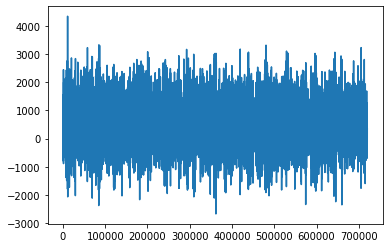

In [198]:
plt.plot(st1[0].data)

In [ ]:
tt=1/tr1.stats.sampling_rate*np.array(range(tr1.stats.npts))

def wf_section(tr1,start_t,stop_t,tt):
    max_ind=np.argmax((np.abs(tr1.data-np.mean(tr1.data))))
    start_ind=max_ind+int(tr1.stats.sampling_rate*start_t)
    stop_ind=max_ind+int(tr1.stats.sampling_rate*stop_t)
    if start_ind<0:
        start_ind=0
        
    if stop_ind>len(tt):
        stop_ind=len(tt)
    
    tt_slice=tt[start_ind:stop_ind]
    wf_slice=tr1.data[start_ind:stop_ind]
    
    return wf_slice, tt_slice

In [281]:
def trace_section(tr1, quake_time, time_before, time_duration, step1=1):
    #takes a trace tr1, time of quake, start time and duration of section, and optional step arguement
    #returns a section of the trace data over the defined time, with the correct step
    tt=np.linspace(float(tr1.stats.starttime),float(tr1.stats.endtime),tr1.stats.npts)
    start_ind=np.argmax(tt>(quake_time-time_before))
    stop_ind=start_ind+int(np.ceil(time_duration*tr1.stats.sampling_rate))
#     print(start_ind)
#     print(stop_ind)
    tr_section=tr1.data[start_ind:stop_ind:step1]
    tt_section=tt[start_ind:stop_ind:step1]
    
    return tr_section, tt_section

In [282]:
int(1.3)

1

In [294]:
time(trace_section(tr1,(float(tr1.stats.starttime)+float(tr1.stats.endtime))/2,55*60,115*60))

CPU times: user 10.1 ms, sys: 7.72 ms, total: 17.8 ms
Wall time: 16.3 ms


(array([-841, -798, -869, ..., 1243, 1286, 1205], dtype=int32),
 array([  1.56900567e+09,   1.56900567e+09,   1.56900567e+09, ...,
          1.56901257e+09,   1.56901257e+09,   1.56901257e+09]))

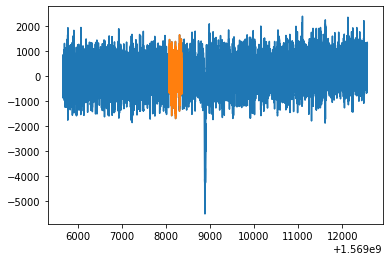

In [277]:
plt.plot(tt_section1,tr_section1)
plt.plot(tt_section,tr_section)

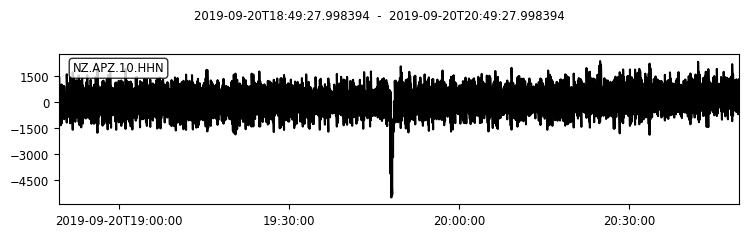

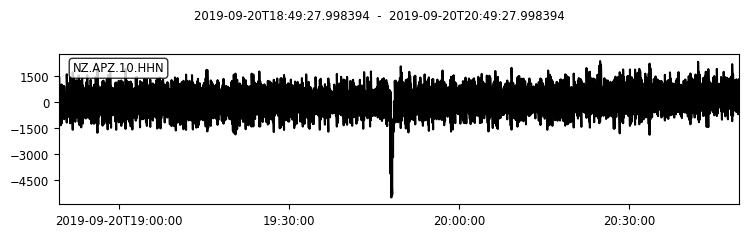

In [275]:
tr1.plot()

In [268]:
aa=[1,2,3,4,5,6,7,8,9,10]
aa[0:7:2]

[1, 3, 5, 7]

In [242]:
np.argmin([1,1,1,1,0,0,0])

4

In [241]:
tt=np.linspace(float(tr1.stats.starttime),float(tr1.stats.endtime),tr1.stats.npts)
tt

array([  1.56900537e+09,   1.56900537e+09,   1.56900537e+09, ...,
         1.56901257e+09,   1.56901257e+09,   1.56901257e+09])

In [236]:
tr1.stats

               network: NZ
               station: APZ
              location: 10
               channel: HHN
             starttime: 2019-09-20T18:49:27.998394Z
               endtime: 2019-09-20T20:49:27.998394Z
         sampling_rate: 100.0
                 delta: 0.01
                  npts: 720001
                 calib: 1.0
_fdsnws_dataselect_url: http://service.geonet.org.nz/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1748, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 2595840})
            processing: ['ObsPy 1.2.1: trim(endtime=UTCDateTime(2019, 9, 20, 20, 49, 27, 998394)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2019, 9, 20, 18, 49, 27, 998394))']
              response: Channel Response
	From m/s () to count ()
	Overall Sensitivity: 8.38861e+08 defined at 1.000 Hz
	3 stages:
		Stage 1: PolesZerosResponseStage from m/s to V, gain: 

In [306]:
time_before=15*60 #number of seconds before the quake to start section
time_duration= 5*60 # number of seconds that the section starts for 
#probably update these to be more random; change time before to be a range 12-18 mins

for quake_i in range(2):#range(len(quakelist_new)): #for all the quakes with good data
    for station in stations_over_min: # for all the stations
        foldername='data/'+quakelist_new['eventid'][quake_i]+'/'
        filename=station+'.pkl'
        quake_time=UTCDateTime(quakelist_new.iloc[quake_i]['time']) #this is the time of the quake
        #will need to change that because the time of the quake recorded is often different from the actual quake time
        with open(foldername+filename,'rb') as f: 
            st1= pickle.load(f) #load the station data for the quake
            for tr in st1: # for each trace, shoud change this to be just HHE HHN HHZ
                # take into account for different sampling rates, I think 100Hz is the lowest, so convert to that 
                if tr.stats.channel == 'HHN' or tr.stats.channel == 'HHE' or tr.stats.channel == 'HHZ':
                    if tr.stats.sampling_rate==100.0: 
                        tr_section, tt_section=trace_section(tr,quake_time,time_before,time_duration,step1=1)
                        print(len(tr_section))
                    elif tr.stats.sampling_rate==200.0:
                        tr_section, tt_section=trace_section(tr,quake_time,time_before,time_duration,step1=1)
                        print(len(tr_section))

                    else:
                        print('whaaaaat')

30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
8100
2600
1700
4300
8100
2600
1700
4300
8100
2600
1700
4300
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
3397
100
4700
6700
5300
4600
100
8700
5000
5800
6900
8000
5800
5600
200
1280

SystemError: <built-in function isinstance> returned a result with an error set

In [371]:
time_before=15*60 #number of seconds before the quake to start section
time_duration= 5*60 # number of seconds that the section starts for 
#probably update these to be more random; change time before to be a range 12-18 mins
stations_to_remove=[]
for quake_i in range(len(quakelist_new)): #for all the quakes with good data
    for station in stations_over_min: # for all the stations
        foldername='data/'+quakelist_new['eventid'][quake_i]+'/'
        filename=station+'.pkl'
        quake_time=UTCDateTime(quakelist_new.iloc[quake_i]['time']) #this is the time of the quake
        #will need to change that because the time of the quake recorded is often different from the actual quake time
#         print(station)
        with open(foldername+filename,'rb') as f: 
            st1= pickle.load(f) #load the station data for the quake
            for tr in st1[0:3]: # for each trace, shoud change this to be just HHE HHN HHZ
                if not (tr.stats.channel == 'HHN' or tr.stats.channel == 'HHE' or tr.stats.channel == 'HHZ'
                       or tr.stats.channel == 'HH2' or tr.stats.channel == 'HH1'):
                    print(tr)
                    if station not in stations_to_remove:
                        stations_to_remove.append(station)
                if not (tr.stats.npts==720001 or tr.stats.npts==720000):
                    print(tr)
                    if station not in stations_to_remove:
                        stations_to_remove.append(station)
                if tr.stats.npts>720002:
                    print(tr)
                    print('===============LOOK HERE===============')
                    print('===============LOOK HERE===============')
                    print('===============LOOK HERE===============')
                    print('===============LOOK HERE===============')
#                 if not tr.stats.sampling_rate ==100.0:
#                     print(tr)
#                     stations_to_remove([station])
#                 if tr.stats.channel == 'HHN' or tr.stats.channel == 'HHE' or tr.stats.channel == 'HHZ':
#                     if tr.stats.sampling_rate==100.0: 

#                     elif tr.stats.sampling_rate==200.0:

#                     else:
#                         print('whaaaaat')

NZ.OPRZ.10.HHE | 2013-06-27T17:50:07.968396Z - 2013-06-27T17:51:28.958396Z | 100.0 Hz, 8100 samples
NZ.OPRZ.10.HHE | 2013-06-27T17:58:10.968396Z - 2013-06-27T17:58:36.958396Z | 100.0 Hz, 2600 samples
NZ.OPRZ.10.HHE | 2013-06-27T17:59:00.968396Z - 2013-06-27T17:59:17.958396Z | 100.0 Hz, 1700 samples
NZ.TRVZ.10.HHE | 2013-06-27T16:00:28.998393Z - 2013-06-27T16:01:02.958393Z | 100.0 Hz, 3397 samples
NZ.TRVZ.10.HHE | 2013-06-27T16:01:11.968393Z - 2013-06-27T16:01:12.958393Z | 100.0 Hz, 100 samples
NZ.TRVZ.10.HHE | 2013-06-27T16:02:25.968393Z - 2013-06-27T16:03:12.958393Z | 100.0 Hz, 4700 samples
NZ.OTVZ.10.HHE | 2019-08-07T00:00:49.963138Z - 2019-08-07T01:43:01.003138Z | 100.0 Hz, 613105 samples
NZ.OTVZ.10.HHN | 2019-08-07T00:00:49.963138Z - 2019-08-07T01:43:01.003138Z | 100.0 Hz, 613105 samples
NZ.OTVZ.10.HHZ | 2019-08-07T00:00:49.963138Z - 2019-08-07T01:43:01.003138Z | 100.0 Hz, 613105 samples
NZ.APZ.10.HHE | 2019-01-30T03:14:43.968394Z - 2019-01-30T03:59:33.998394Z | 100.0 Hz, 269004 sa

NZ.WAZ.10.HHE | 2019-05-08T06:38:47.999447Z - 2019-05-08T07:01:11.839447Z | 100.0 Hz, 134385 samples
NZ.WAZ.10.HHE | 2019-05-08T07:01:19.968389Z - 2019-05-08T08:38:47.998389Z | 100.0 Hz, 584804 samples
NZ.WAZ.10.HHN | 2019-05-08T06:38:47.999447Z - 2019-05-08T07:01:11.839447Z | 100.0 Hz, 134385 samples
NZ.WAZ.10.HHE | 2019-08-03T20:32:14.995697Z - 2019-08-03T21:01:41.875697Z | 100.0 Hz, 176689 samples
NZ.WAZ.10.HHE | 2019-08-03T21:01:49.968388Z - 2019-08-03T22:32:14.998388Z | 100.0 Hz, 542504 samples
NZ.WAZ.10.HHN | 2019-08-03T20:32:14.995697Z - 2019-08-03T21:01:41.875697Z | 100.0 Hz, 176689 samples
NZ.WAZ.10.HHE | 2019-07-28T05:35:54.996450Z - 2019-07-28T07:01:05.876450Z | 100.0 Hz, 511089 samples
NZ.WAZ.10.HHE | 2019-07-28T07:01:07.968389Z - 2019-07-28T07:35:54.998389Z | 100.0 Hz, 208704 samples
NZ.WAZ.10.HHN | 2019-07-28T05:35:54.996450Z - 2019-07-28T07:01:05.876450Z | 100.0 Hz, 511089 samples
NZ.WAZ.10.HHE | 2020-01-16T13:13:19.999785Z - 2020-01-16T14:01:40.939785Z | 100.0 Hz, 29009

NZ.TUZ.10.HHE | 2019-02-13T20:06:43.997249Z - 2019-02-13T20:26:17.557249Z | 100.0 Hz, 117357 samples
NZ.TUZ.10.HHE | 2019-02-13T20:26:18.968269Z - 2019-02-13T20:29:03.958269Z | 100.0 Hz, 16500 samples
NZ.TUZ.10.HHN | 2019-02-13T20:06:43.997249Z - 2019-02-13T20:26:16.927249Z | 100.0 Hz, 117294 samples
NZ.VRZ.10.HHE | 2019-02-13T20:06:44.003305Z - 2019-02-13T20:26:15.273305Z | 100.0 Hz, 117128 samples
NZ.VRZ.10.HHE | 2019-02-13T20:26:17.963107Z - 2019-02-13T22:06:44.003107Z | 100.0 Hz, 602605 samples
NZ.VRZ.10.HHN | 2019-02-13T20:06:44.003305Z - 2019-02-13T20:26:15.953305Z | 100.0 Hz, 117196 samples
NZ.WAZ.10.HHE | 2019-02-13T20:06:43.998389Z - 2019-02-13T20:26:17.728389Z | 100.0 Hz, 117374 samples
NZ.WAZ.10.HHE | 2019-02-13T20:26:18.968400Z - 2019-02-13T22:06:43.998400Z | 100.0 Hz, 602504 samples
NZ.WAZ.10.HHN | 2019-02-13T20:06:43.998389Z - 2019-02-13T20:26:17.528389Z | 100.0 Hz, 117354 samples
NZ.WHZ.10.HHE | 2019-02-13T20:06:44.003130Z - 2019-02-13T20:26:15.743130Z | 100.0 Hz, 117175

In [370]:
foldername='data/'+quakelist_new['eventid'][0]+'/'
with open(foldername+'RPZ.pkl','rb') as f: 
    st1= pickle.load(f)
print(st1)

3 Trace(s) in Stream:
NZ.RPZ.10.HH1 | 2013-06-27T16:00:29.000867Z - 2013-06-27T18:00:29.000867Z | 100.0 Hz, 720001 samples
NZ.RPZ.10.HH2 | 2013-06-27T16:00:29.000867Z - 2013-06-27T18:00:29.000867Z | 100.0 Hz, 720001 samples
NZ.RPZ.10.HHZ | 2013-06-27T16:00:29.000867Z - 2013-06-27T18:00:29.000867Z | 100.0 Hz, 720001 samples


In [351]:
st1[0].stats.sampling_rate

100.0

In [361]:
aa=['hi','ho','hee']

In [362]:
aa.append('yes')

In [374]:
len(stations_to_remove),len(stations_over_min)

(38, 65)

In [231]:
float(UTCDateTime(quakelist_new.iloc[0]['time']))

1372352429.0

In [145]:
all([station in file_list_str for station in stations_over_min])

True

In [111]:
foldername1[5:-1]

'2015p511398'

In [74]:
sum(n_quakes>200)

65

In [39]:
1+1

2

In [40]:
st1

4 Trace(s) in Stream:
NZ.TMVZ.10.HHE | 2015-07-09T04:12:51.998391Z - 2015-07-09T06:12:51.998391Z | 100.0 Hz, 720001 samples
NZ.TMVZ.10.HHN | 2015-07-09T04:12:51.998391Z - 2015-07-09T06:12:51.998391Z | 100.0 Hz, 720001 samples
NZ.TMVZ.10.HHZ | 2015-07-09T04:12:51.998391Z - 2015-07-09T06:12:51.998391Z | 100.0 Hz, 720001 samples
NZ.TMVZ.30.HDF | 2015-07-09T04:12:51.998391Z - 2015-07-09T06:12:51.998391Z | 100.0 Hz, 720001 samples

In [134]:
filename1[:-4]

'TMVZ'

(array([  1.96600000e+03,   1.53400000e+03,   1.46600000e+03,
          1.19400000e+03,   9.11000000e+02,   7.08000000e+02,
          6.58000000e+02,   2.74000000e+02,   1.86000000e+02,
          1.17000000e+02,   8.30000000e+01,   5.20000000e+01,
          3.20000000e+01,   2.80000000e+01,   1.10000000e+01,
          8.00000000e+00,   7.00000000e+00,   4.00000000e+00,
          0.00000000e+00,   1.00000000e+00]),
 array([ 4.   ,  4.215,  4.43 ,  4.645,  4.86 ,  5.075,  5.29 ,  5.505,
         5.72 ,  5.935,  6.15 ,  6.365,  6.58 ,  6.795,  7.01 ,  7.225,
         7.44 ,  7.655,  7.87 ,  8.085,  8.3  ]),
 <a list of 20 Patch objects>)

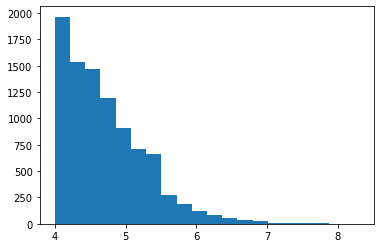

In [188]:
plt.hist(quakelist['magnitude'].to_numpy(),bins=20)

In [191]:
sum(quakelist['magnitude']>6)

272

In [190]:
sum(quakelist['magnitude']>1)

9240

In [41]:
file_list2=os.listdir('data/2013p141077/')
st1=np.zeros(len(file_list2),dtype=object)
for ii, filename in enumerate(file_list2):
    with open('data/2013p141077/'+filename,'rb') as f:
        st1[ii]= pickle.load(f)

In [42]:
for ii in range(len(st1)):
    print(st1[ii])

3 Trace(s) in Stream:
NZ.INZ.10.HHE | 2013-02-22T03:46:13.998386Z - 2013-02-22T05:46:13.998386Z | 100.0 Hz, 720001 samples
NZ.INZ.10.HHN | 2013-02-22T03:46:13.998386Z - 2013-02-22T05:46:13.998386Z | 100.0 Hz, 720001 samples
NZ.INZ.10.HHZ | 2013-02-22T03:46:13.998386Z - 2013-02-22T05:46:13.998386Z | 100.0 Hz, 720001 samples
3 Trace(s) in Stream:
NZ.APZ.10.HHE | 2013-02-22T03:46:13.998393Z - 2013-02-22T05:46:13.998393Z | 100.0 Hz, 720001 samples
NZ.APZ.10.HHN | 2013-02-22T03:46:13.998393Z - 2013-02-22T05:46:13.998393Z | 100.0 Hz, 720001 samples
NZ.APZ.10.HHZ | 2013-02-22T03:46:13.998393Z - 2013-02-22T05:46:13.998393Z | 100.0 Hz, 720001 samples
3 Trace(s) in Stream:
NZ.VRZ.10.HHE | 2013-02-22T03:46:14.000860Z - 2013-02-22T05:46:14.000860Z | 100.0 Hz, 720001 samples
NZ.VRZ.10.HHN | 2013-02-22T03:46:14.000859Z - 2013-02-22T05:46:14.000859Z | 100.0 Hz, 720001 samples
NZ.VRZ.10.HHZ | 2013-02-22T03:46:14.000860Z - 2013-02-22T05:46:14.000860Z | 100.0 Hz, 720001 samples
3 Trace(s) in Stream:
NZ.

5 Trace(s) in Stream:
NZ.COVZ.10.HH1 | 2013-02-22T03:46:13.998393Z - 2013-02-22T05:46:13.998393Z | 100.0 Hz, 720001 samples
NZ.COVZ.10.HH2 | 2013-02-22T03:46:13.998393Z - 2013-02-22T05:46:13.998393Z | 100.0 Hz, 720001 samples
NZ.COVZ.10.HHZ | 2013-02-22T03:46:13.998393Z - 2013-02-22T05:46:13.998393Z | 100.0 Hz, 720001 samples
NZ.COVZ.30.HDA | 2013-02-22T03:46:13.998393Z - 2013-02-22T05:46:13.998393Z | 100.0 Hz, 720001 samples
NZ.COVZ.30.HDF | 2013-02-22T03:46:13.998393Z - 2013-02-22T05:46:13.998393Z | 100.0 Hz, 720001 samples
3 Trace(s) in Stream:
NZ.MAVZ.10.HH1 | 2013-02-22T03:46:13.998394Z - 2013-02-22T05:46:13.998394Z | 100.0 Hz, 720001 samples
NZ.MAVZ.10.HH2 | 2013-02-22T03:46:13.998394Z - 2013-02-22T05:46:13.998394Z | 100.0 Hz, 720001 samples
NZ.MAVZ.10.HHZ | 2013-02-22T03:46:13.998394Z - 2013-02-22T05:46:13.998394Z | 100.0 Hz, 720001 samples
5 Trace(s) in Stream:
NZ.WIZ.10.HHE | 2013-02-22T03:46:13.998393Z - 2013-02-22T05:46:13.998393Z | 100.0 Hz, 720001 samples
NZ.WIZ.10.HHN | 2

In [234]:
def peak_time(stream_list):
    
    pt=np.inf
    for st in stream_list:
        for tr in st:
            tt=1/tr.stats.sampling_rate*np.array(range(tr.stats.npts))
            

In [235]:
peak_time(st1)

TypeError: only size-1 arrays can be converted to Python scalars

In [238]:
tr1.stats.starttime+10000>tr1.stats.starttime+100

True

In [1]:
st1[18].plot()

NameError: name 'st1' is not defined

In [3]:
st1[0][1].std()

NameError: name 'st1' is not defined

In [70]:
def plot_stream(st1,step=10,figsize=[14,12]):
    n_t=len(st1)
    fig1=plt.figure(figsize=figsize)
    for ii in range(n_t):
        fig1.add_subplot(n_t,1,ii+1)
        tt=1/st1[ii].stats.sampling_rate*np.array(range(st1[ii].stats.npts))
        mid_ind=int((st1[ii].stats.npts-1)/2)
        
        plt.plot(tt[0:-1:step],st1[ii].data[0:-1:step])
        plt.plot(np.ones(2)*tt[mid_ind],[max(st1[ii].data),min(st1[ii].data)])
        plt.title(st1[ii].stats.station + ', ' +st1[ii].stats.channel)

In [91]:
def plot_stream(st1,step=10,figsize=[14,12]):
    n_t=len(st1)
    fig1=plt.figure(figsize=figsize)
    for ii in range(n_t):
        fig1.add_subplot(n_t,1,ii+1)
        tt=1/st1[ii].stats.sampling_rate*np.array(range(st1[ii].stats.npts))
        mid_ind=int((st1[ii].stats.npts-1)/2)
        p3=np.poly1d(np.polyfit(tt[0:-1:step],st1[ii].data[0:-1:step],3))
        data1=st1[ii].data[0:-1:step]-p3(tt[0:-1:step])
        plt.plot(tt[0:-1:step],data1)
        plt.plot(np.ones(2)*tt[mid_ind],[max(data1),min(data1)])
        plt.title(st1[ii].stats.station + ', ' +st1[ii].stats.channel)

In [92]:
st1[0][0].stats

               network: NZ
               station: INZ
              location: 10
               channel: HHE
             starttime: 2013-02-22T03:46:13.998386Z
               endtime: 2013-02-22T05:46:13.998386Z
         sampling_rate: 100.0
                 delta: 0.01
                  npts: 720001
                 calib: 1.0
_fdsnws_dataselect_url: http://service.geonet.org.nz/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1275, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 1973760})
            processing: ['ObsPy 1.2.1: trim(endtime=UTCDateTime(2013, 2, 22, 5, 46, 13, 998386)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2013, 2, 22, 3, 46, 13, 998386))']
              response: Channel Response
	From m/s () to count ()
	Overall Sensitivity: 8.38861e+08 defined at 1.000 Hz
	3 stages:
		Stage 1: PolesZerosResponseStage from m/s to V, gain: 20

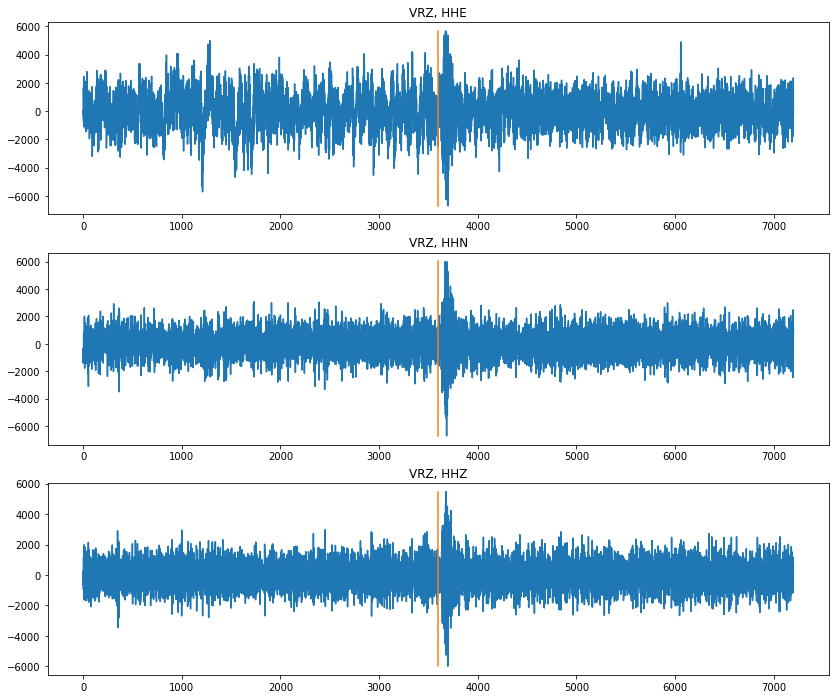

In [95]:
plot_stream(st1[2])

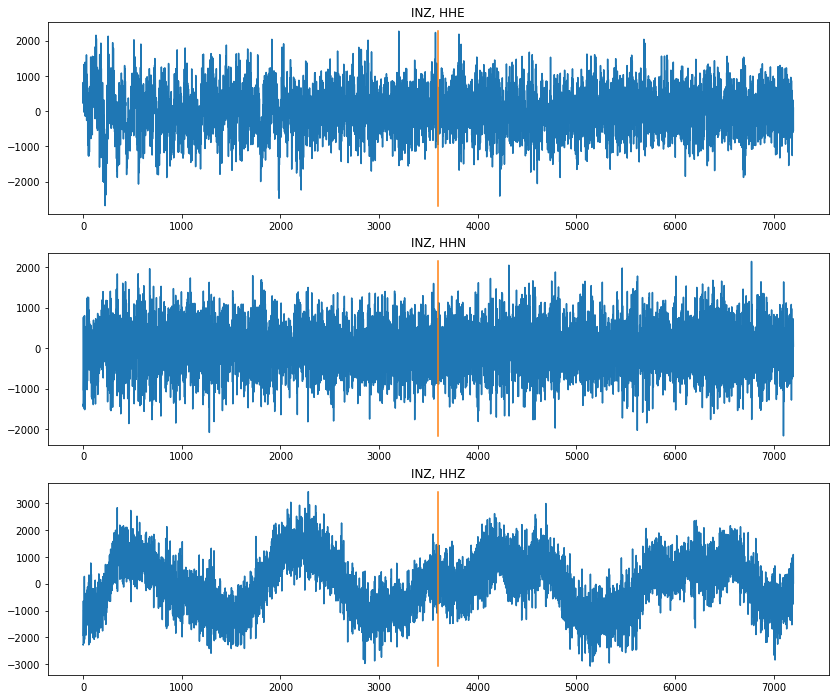

AttributeError: module 'matplotlib.pyplot' has no attribute 'clear'

In [101]:
for ii in range(len(st1)):
    plot_stream(st1[ii])
    plt.show()
    input()

In [131]:
def plot_stream_list(sl,step=10,figsize=[14,21]):
    n_s=len(sl)
    plot_num=1
    fig1=plt.figure(figsize=figsize)
    for jj in range(len(sl)):
        for ii in range(3):
            fig1.add_subplot(n_s,3,plot_num)
            plot_num=plot_num+1
            tt=1/sl[jj][ii].stats.sampling_rate*np.array(range(sl[jj][ii].stats.npts))
            mid_ind=int((sl[jj][ii].stats.npts-1)/2)
        
            plt.plot(tt[0:-1:step],sl[jj][ii].data[0:-1:step])
            plt.plot(np.ones(2)*tt[mid_ind],[max(sl[jj][ii].data),min(sl[jj][ii].data)])
            plt.title(sl[jj][ii].stats.station + ', ' +sl[jj][ii].stats.channel)

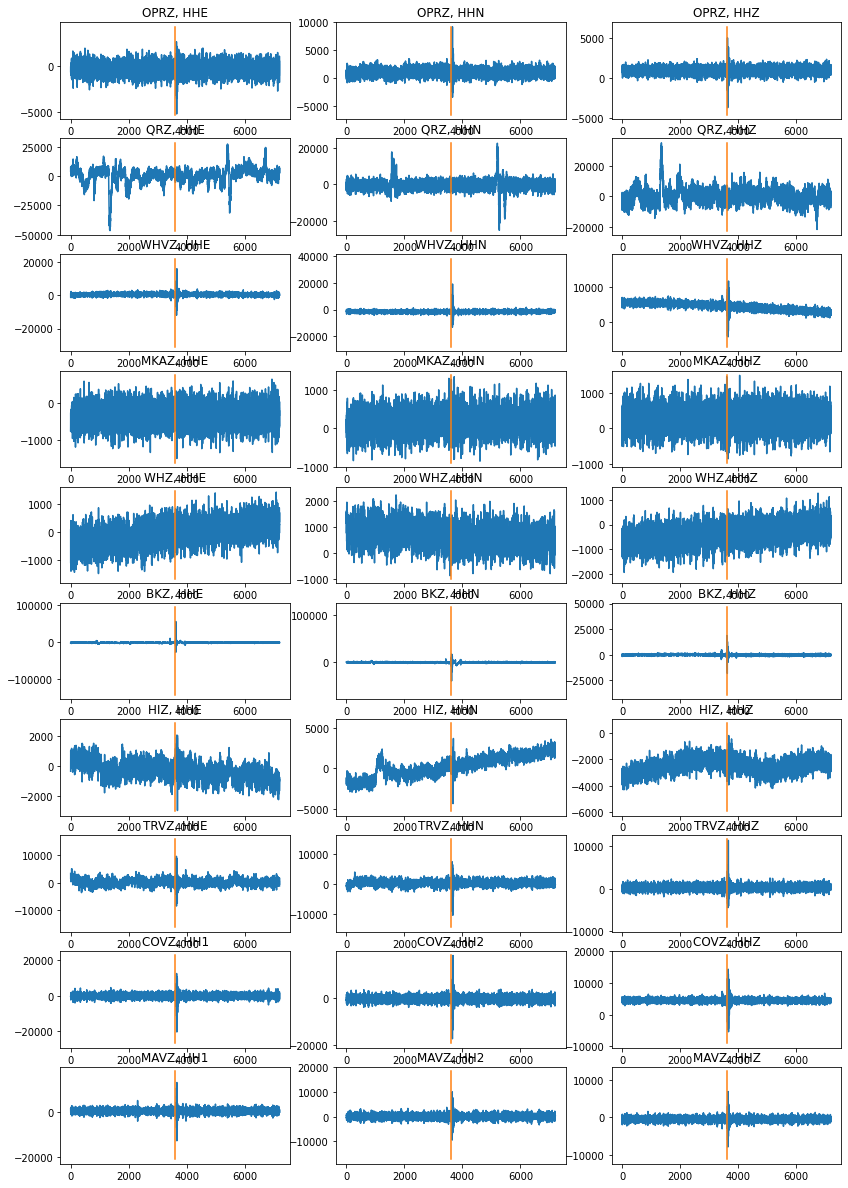

In [134]:
n=20
plot_stream_list(st1[n:n+10],step=100)

In [135]:
len(st1)

63

In [114]:
st1[9]

3 Trace(s) in Stream:
NZ.OUZ.10.HHE | 2013-02-22T03:46:13.998389Z - 2013-02-22T05:46:13.998389Z | 100.0 Hz, 720001 samples
NZ.OUZ.10.HHN | 2013-02-22T03:46:13.998389Z - 2013-02-22T05:46:13.998389Z | 100.0 Hz, 720001 samples
NZ.OUZ.10.HHZ | 2013-02-22T03:46:13.998389Z - 2013-02-22T05:46:13.998389Z | 100.0 Hz, 720001 samples

In [130]:
st1[10]

3 Trace(s) in Stream:
NZ.GLKZ.10.HHE | 2013-02-22T03:46:13.998389Z - 2013-02-22T05:46:13.998389Z | 100.0 Hz, 720001 samples
NZ.GLKZ.10.HHN | 2013-02-22T03:46:13.998389Z - 2013-02-22T05:46:13.998389Z | 100.0 Hz, 720001 samples
NZ.GLKZ.10.HHZ | 2013-02-22T03:46:14.008389Z - 2013-02-22T05:46:13.998389Z | 100.0 Hz, 720000 samples

In [91]:
station_list1=['APZ', 'BFZ', 'BKZ', 'COVZ', 'CTZ', 'DCZ', 'DSZ', 'EAZ', 'FOZ',
       'FWVZ', 'GLKZ', 'GRZ', 'GVZ', 'HAZ', 'HIZ', 'INZ', 'JCZ', 'KHEZ',
       'KHZ', 'KNZ',  'LBZ', 'LTZ', 'MAVZ', 'MKAZ', 'MLZ', 'MQZ',
       'MRZ', 'MSZ', 'MWZ', 'MXZ', 'NNZ', 'ODZ', 'OPRZ', 'OPZ', 'OTVZ',
       'OUZ', 'OXZ', 'PUZ', 'PXZ', 'PYZ', 'QRZ', 'RATZ', 'RIZ', 'RPZ',
       'RTZ', 'SYZ', 'THZ', 'TLZ', 'TMVZ', 'TOZ', 'TRVZ', 'TSZ', 'TUZ',
       'URZ', 'VRZ', 'WAZ', 'WCZ', 'WEL', 'WHVZ', 'WHZ', 'WIZ', 'WKZ',
       'WSRZ', 'WVZ']

In [63]:
station_list1=['APZ', 'BFZ', 'BKZ', 'CTZ', 'DSZ', 'EAZ', 'FOZ',
       'FWVZ', 'GLKZ', 'GRZ', 'GVZ', 'HAZ', 'HIZ', 'INZ', 'JCZ', 'KHEZ',
       'KHZ', 'KNZ',  'LBZ', 'LTZ', 'MAVZ', 'MLZ', 'MQZ',
       'MRZ', 'MSZ', 'MWZ', 'MXZ', 'NNZ', 'ODZ', 'OPRZ', 'OPZ', 'OTVZ',
       'OUZ', 'OXZ', 'PUZ', 'PXZ', 'PYZ', 'QRZ', 'RATZ', 'RIZ', 'RPZ',
       'RTZ', 'SYZ', 'THZ', 'TLZ', 'TMVZ', 'TOZ', 'TRVZ', 'TSZ', 'TUZ',
       'URZ', 'VRZ', 'WAZ', 'WCZ', 'WEL', 'WHVZ', 'WHZ', 'WIZ', 'WKZ',
       'WSRZ', 'WVZ']

In [100]:
data_dir='/media/peter/data/earthquakenz/data/waveforms2/'
folderlist=glob(data_dir+'*/')
with open(folderlist[1]+'APZ'+'.pkl','rb') as f:
    st1= pickle.load(f)

In [101]:
quakelist_new=pd.DataFrame(columns=quakelist.columns) #new dataframe to put the new quake details into
for foldername1 in folderlist:
    #if this quake file contains all the waveforms for the stations in stations_over_min 
    #then add the row from quakelist that matches the quakeid to quakelist_new
    file_list1=os.listdir(foldername1)
    file_list_str=''.join(file_list1)
    if all([station in file_list_str for station in station_list1]): #if all the stations are there
        quakelist_new=quakelist_new.append(quakelist[quakelist['eventid']==foldername1[-12:-1]],ignore_index=True)#add the correct quake info


In [66]:
folderlist[0][-12:-1]

'2014p934733'

In [90]:
stationlist

,#network,station,latitude,longitude,elevation,sitename,starttime,endtime,n_quakes
0,NZ,APZ,-46.831806,167.988825,601.0,The Paps,2006-05-07T00:00:00,NaN,227.0
1,NZ,BFZ,-40.679647,176.246245,283.0,Birch Farm,1996-04-03T00:00:00,NaN,230.0
2,NZ,BHW,-41.408231,174.871115,101.0,Baring Head,1975-11-27T00:00:00,NaN,140.0
3,NZ,BKZ,-39.165666,176.492544,706.0,Black Stump Farm,2004-02-11T00:00:00,NaN,224.0
4,NZ,COVZ,-39.199914,175.542402,1133.0,Chateau Observatory,1998-03-25T00:00:00,NaN,231.0
...,...,...,...,...,...,...,...,...,...
69,NZ,WHZ,-45.892428,167.947031,345.0,Wether Hill Road,1993-03-22T00:00:00,NaN,230.0
70,NZ,WIZ,-37.524511,177.189302,40.0,White Island,1976-12-12T00:00:00,NaN,228.0
71,NZ,WKZ,-44.827021,169.017562,558.0,Wanaka,2004-06-03T00:00:00,NaN,228.0
72,NZ,WSRZ,-37.518110,177.177805,292.4,White Island Summit,2013-04-08T00:00:00,NaN,213.0


In [102]:
len(quakelist_new), len(station_list1)

(996, 58)

In [115]:
# station_list1=['APZ', 'BFZ', 'BKZ', 'CTZ', 'DSZ', 'EAZ', 'FOZ',
#        'FWVZ', 'GLKZ', 'GRZ', 'GVZ', 'HAZ', 'HIZ', 'INZ', 'JCZ', 'KHEZ',
#        'KHZ', 'KNZ',  'LBZ', 'LTZ', 'MLZ', 'MQZ',
#        'MRZ', 'MSZ', 'MWZ', 'MXZ', 'NNZ', 'ODZ', 'OPRZ', 'OPZ',
#        'OUZ', 'OXZ', 'PUZ', 'PXZ', 'PYZ', 'QRZ', 'RATZ', 'RIZ',
#        'RTZ', 'SYZ', 'THZ', 'TLZ', 'TMVZ', 'TOZ', 'TRVZ', 'TSZ', 'TUZ',
#         'VRZ', 'WAZ',  'WEL', 'WHVZ', 'WHZ', 'WIZ', 'WKZ',
#        'WSRZ', 'WVZ']

# station_list1=['APZ', 'BFZ', 'BKZ', 'CTZ',  'DSZ', 'EAZ', 'FOZ',
#        'FWVZ', 'GLKZ', 'GRZ', 'GVZ', 'HAZ', 'HIZ', 'INZ', 'JCZ', 'KHEZ',
#        'KHZ', 'KNZ',  'LBZ', 'LTZ', 'MLZ', 'MQZ',
#        'MRZ', 'MSZ', 'MWZ', 'MXZ', 'NNZ', 'ODZ', 'OPRZ', 'OPZ', 'OTVZ',
#        'OUZ', 'OXZ', 'PUZ', 'PXZ', 'PYZ', 'QRZ', 'RATZ', 'RIZ', 
#        'RTZ', 'SYZ', 'THZ', 'TLZ', 'TMVZ', 'TOZ', 'TRVZ', 'TSZ', 'TUZ',
#         'VRZ', 'WAZ', 'WCZ', 'WEL', 'WHVZ', 'WHZ', 'WIZ', 'WKZ',
#        'WSRZ', 'WVZ']
station_list1=['APZ', 'BFZ', 'BKZ', 'CTZ',  'DSZ', 'EAZ', 'FOZ',
       'FWVZ', 'GLKZ', 'GRZ', 'GVZ', 'HAZ', 'HIZ', 'INZ', 'JCZ', 'KHEZ',
       'KHZ', 'KNZ',  'LBZ', 'LTZ', 'MLZ', 'MQZ',
       'MRZ', 'MSZ', 'MWZ', 'MXZ', 'NNZ', 'ODZ', 'OPRZ', 'OPZ', 'OTVZ',
       'OUZ', 'OXZ', 'PUZ', 'PXZ', 'PYZ', 'QRZ', 'RATZ', 'RIZ', 
       'RTZ', 'SYZ', 'THZ', 'TLZ', 'TMVZ', 'TOZ', 'TRVZ', 'TSZ', 'TUZ',
        'VRZ', 'WAZ', 'WCZ', 'WEL', 'WHVZ', 'WHZ', 'WIZ', 'WKZ',
       'WSRZ', 'WVZ']
goodquake=0
badquake=0
badquake_list=[]
for quake_ind in range(len(quakelist_new)):
    foldername1=data_dir+quakelist_new['eventid'][quake_ind]
    #if this quake file contains all the waveforms for the stations in stations_over_min 
    #then add the row from quakelist that matches the quakeid to quakelist_new
#     file_list1=os.listdir(foldername1)

    somethingwrong=0

    for file1 in station_list1:
        with open(foldername1+'/'+file1+'.pkl','rb') as f:
            st1=pickle.load(f)
            if len(st1)<3:
                somethingwrong=1
            else:
                for ii in range(3):
                    if all([st1[ii].stats.npts!=32001, st1[ii].stats.npts!=32000]) or all([st1[ii].stats.channel!='HHE', st1[ii].stats.channel!='HHZ', st1[ii].stats.channel!='HHN']):
                        somethingwrong=1
    if somethingwrong:
        print(quakelist_new['eventid'][quake_ind])
        badquake+=1
        badquake_list.append(quakelist_new['eventid'][quake_ind])
    else:
        goodquake+=1

        
quakelist_new.drop(quakelist_new.index[[eventid in badquake_list for eventid in quakelist_new['eventid']] ],inplace=True)
quakelist_new.reset_index(drop=True,inplace=True)

2017p614980
2017p615484
2017p615815
2017p626052
2013p763375
2013p763924
2013p771095
2014p293855
2014p338353
2014p338568
2020p042145
2020p109716
2015p484723
2016p150363
2016p154584
2019p871867
2018p464560
2020p196991
2014p180390
2016p047495
2017p503780
2017p537399
2015p319700
2019p108878
2019p109766
2019p110046
2019p461853
2013p916955
2013p921843
2017p708005
2016p140897
2016p141671
2016p324202
2016p324856
2016p327102
2016p915125
2013p473965
2013p477623


In [114]:
goodquake/58, badquake

(995.3275862068965, 39)

In [130]:
for ii in range(len(quakelist_new)):
    if quakelist_new['eventid'][ii] in badquake_list:
        quakelist_new.drop(ii)
        print(quakelist_new['eventid'][ii])

2017p614980
2017p615484
2017p615815
2017p626052
2013p763375
2013p763924
2013p771095
2014p293855
2014p338353
2014p338568
2020p042145
2020p109716
2015p484723
2016p150363
2016p154584
2019p871867
2018p464560
2020p196991
2014p180390
2016p047495
2017p503780
2017p537399
2015p319700
2019p108878
2019p109766
2019p110046
2019p461853
2013p916955
2013p921843
2017p708005
2016p140897
2016p141671
2016p324202
2016p324856
2016p327102
2016p915125
2013p473965
2013p477623


In [137]:
quakelist_new.drop(quakelist_new.index[[eventid in badquake_list for eventid in quakelist_new['eventid']] ],inplace=True)

In [139]:
quakelist_new

,eventid,time,latitude,longitude,depth/km,author,catalog,contributor,contributorid,magtype,magnitude,magauthor,eventlocationname
2,2017p615702,2017-08-16T19:21:58,-30.175,-175.255,33.0,GNS,GNS,GNS,2017p615702,mB,4.8,GNS,1010 km north-east of Te Araroa
4,2017p624298,2017-08-19T23:46:05,-37.027,176.977,193.1,GNS,GNS,GNS,2017p624298,M,4.1,GNS,100 km east of Whangamata
6,2017p633726,2017-08-23T11:29:20,-35.388,-178.857,33.0,GNS,GNS,GNS,2017p633726,M,4.4,GNS,350 km north-east of Te Araroa
7,2017p633915,2017-08-23T13:09:33,-35.329,-178.721,33.0,GNS,GNS,GNS,2017p633915,M,4.0,GNS,360 km north-east of Te Araroa
8,2017p662580,2017-09-03T03:30:01,41.343,129.036,0.0,GNS,GNS,GNS,2017p662580,M,6.1,GNS,9500 km north-west of Cape Reinga
...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,2015p905234,2015-12-01T22:26:14,-32.163,179.593,441.7,GNS,GNS,GNS,2015p905234,M,4.0,GNS,615 km north of Te Araroa
992,2015p905294,2015-12-01T22:59:38,-32.685,-178.482,33.0,GNS,GNS,GNS,2015p905294,M,4.8,GNS,615 km north-east of Te Araroa
993,2015p913352,2015-12-04T22:24:55,-47.640,85.090,10.0,GNS,GNS,GNS,2015p913352,M,6.4,GNS,5795 km south-west of Snares Islands
994,2015p921041,2015-12-07T18:48:55,-30.169,-176.953,263.1,GNS,GNS,GNS,2015p921041,M,4.6,GNS,930 km north-east of Te Araroa


In [129]:
len(quakelist_new)

996

In [113]:
station_list1=['APZ', 'BFZ', 'BKZ', 'CTZ',  'DSZ', 'EAZ', 'FOZ',
       'FWVZ', 'GLKZ', 'GRZ', 'GVZ', 'HAZ', 'HIZ', 'INZ', 'JCZ', 'KHEZ',
       'KHZ', 'KNZ',  'LBZ', 'LTZ', 'MLZ', 'MQZ',
       'MRZ', 'MSZ', 'MWZ', 'MXZ', 'NNZ', 'ODZ', 'OPRZ', 'OPZ', 'OTVZ',
       'OUZ', 'OXZ', 'PUZ', 'PXZ', 'PYZ', 'QRZ', 'RATZ', 'RIZ', 
       'RTZ', 'SYZ', 'THZ', 'TLZ', 'TMVZ', 'TOZ', 'TRVZ', 'TSZ', 'TUZ',
        'VRZ', 'WAZ', 'WCZ', 'WEL', 'WHVZ', 'WHZ', 'WIZ', 'WKZ',
       'WSRZ', 'WVZ']
goodquake=0
badquake=0
for quake_ind in range(len(quakelist_new)):
    foldername1=data_dir+quakelist_new['eventid'][quake_ind]
    #if this quake file contains all the waveforms for the stations in stations_over_min 
    #then add the row from quakelist that matches the quakeid to quakelist_new
#     file_list1=os.listdir(foldername1)
    for file1 in station_list1:
        somethingwrong=0
        with open(foldername1+'/'+file1+'.pkl','rb') as f:
            st1=pickle.load(f)
            if len(st1)<3:
                somethingwrong=1
            else:
                for ii in range(3):
                    if all([st1[ii].stats.npts!=32001, st1[ii].stats.npts!=32000]) or all([st1[ii].stats.channel!='HHE', st1[ii].stats.channel!='HHZ', st1[ii].stats.channel!='HHN']):
                        somethingwrong=1
            if somethingwrong:
                print(st1)
                badquake+=1
            else:
                goodquake+=1

320

In [104]:
len(station_list1)

58

In [164]:
quakeid=quakelist_new['eventid'][100]

print(quakeid)
foldername=data_dir+quakeid
with open(foldername1+'/'+station_list1[0]+'.pkl','rb') as f:
    st1=pickle.load(f)
print(st1)
with open(foldername1+'/'+station_list1[10]+'.pkl','rb') as f:
    st1=pickle.load(f)
print(st1)

2015p774297
3 Trace(s) in Stream:
NZ.APZ.10.HHE | 2016-06-09T08:28:51.238394Z - 2016-06-09T08:34:11.238394Z | 100.0 Hz, 32001 samples
NZ.APZ.10.HHN | 2016-06-09T08:28:51.238394Z - 2016-06-09T08:34:11.238394Z | 100.0 Hz, 32001 samples
NZ.APZ.10.HHZ | 2016-06-09T08:28:51.238394Z - 2016-06-09T08:34:11.238394Z | 100.0 Hz, 32001 samples
3 Trace(s) in Stream:
NZ.GVZ.10.HHE | 2016-06-09T08:28:51.238393Z - 2016-06-09T08:34:11.238393Z | 100.0 Hz, 32001 samples
NZ.GVZ.10.HHN | 2016-06-09T08:28:51.238393Z - 2016-06-09T08:34:11.238393Z | 100.0 Hz, 32001 samples
NZ.GVZ.10.HHZ | 2016-06-09T08:28:51.238393Z - 2016-06-09T08:34:11.238393Z | 100.0 Hz, 32001 samples


In [320]:
def make_datablok(quakeid, data_dir=data_dir, station_list1=station_list1,step=1,normalise=False):
    t_duration=5*60
    samplerate=100
    blok1=np.zeros((int(np.ceil(t_duration*samplerate/step)),3,len(station_list1)))
    starttime=10
    start_times=np.zeros((3,len(station_list1)))
    for station_ind, station in enumerate(station_list1):
        filled=[0,0,0]
        with open(data_dir+ quakeid+'/'+station+'.pkl','rb') as f:
            st1=pickle.load(f)
            for tr_ind in range(3):
                if st1[tr_ind].stats.channel=="HHZ":
                    fill_ind=0
                elif st1[tr_ind].stats.channel=="HHN":
                    fill_ind=1
                elif st1[tr_ind].stats.channel=="HHE":
                    fill_ind=2
                else:
                    print('SOMETHING WRONG WITH THE HH* INDS')
                blok1[:,fill_ind,station_ind]=st1[tr_ind].data[starttime*samplerate:int(t_duration*samplerate)+starttime*samplerate:step]
                filled[fill_ind]=1
                start_times[fill_ind,station_ind]=float(st1[tr_ind].stats.starttime)

            if not filled== [1,1,1]:
                print('NOT FILLED!')
            if station_ind>0:
                if np.max(np.abs(start_times[:,station_ind]-start_times[:,station_ind-1]))>1.5/samplerate:
                    print('Something off with start times around at ' + quakeid+str(station_ind)+', '+station)
                    print(start_times[:,station_ind]-start_times[:,station_ind-1])
                    print(np.max(np.abs(start_times[:,station_ind]-start_times[:,station_ind-1])))
    if normalise:
        blok_std=np.std(blok1,axis=0)
        blok_mean=np.mean(blok1,axis=0)
        for ii in range(3):
            for station_ind in range(len(station_list1)):
                blok1[:,ii,station_ind]=(blok1[:,ii,station_ind]-blok_mean[ii,station_ind])/blok_std[ii,station_ind]
    return blok1, start_times

In [321]:
[1,1,1]-[1,0,1]

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [322]:
quakeid=quakelist_new['eventid'][100]


blok_test, start_times=make_datablok(quakeid,step=10)

FileNotFoundError: [Errno 2] No such file or directory: '/media/peter/data/earthquakenz/data/2015p806441/APZ.pkl'

In [323]:
quakeid=quakelist_new['eventid'][100]
data_dir_waveforms='/media/peter/data/earthquakenz/data/waveforms2/'

data_dir='/media/peter/data/earthquakenz/data/'

blok_test_norm, start_times=make_datablok(quakeid,data_dir=data_dir_waveforms,step=10, normalise=True)

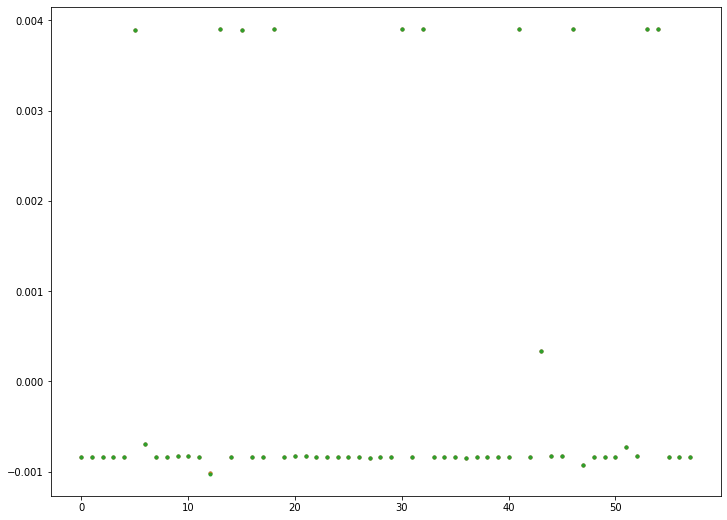

In [324]:
plt.figure(figsize=(12,9))
plt.plot((start_times.T-np.mean(start_times)),'.')

In [327]:
str(str(4))

'4'

In [332]:
np.random.seed(42)
np.random.rand(3)

array([ 0.37454012,  0.95071431,  0.73199394])

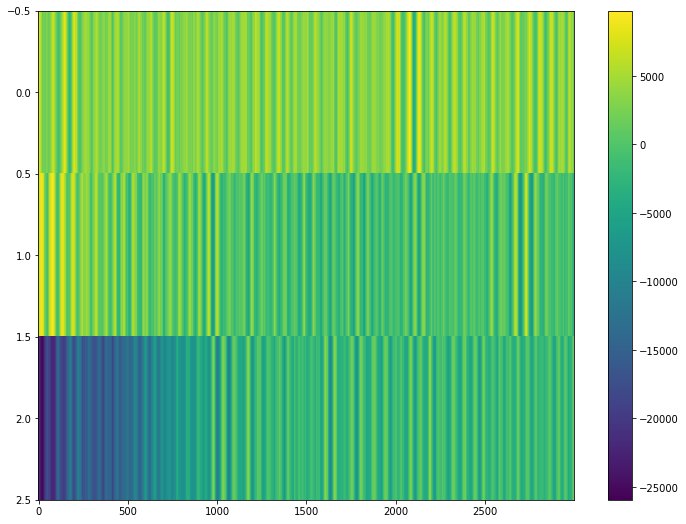

In [325]:
plt.figure(figsize=(12,9))

plt.imshow(blok_test[:,:,1].T,aspect='auto',interpolation='none');
plt.colorbar();

In [326]:
data_dir_waveforms='/media/peter/data/earthquakenz/data/waveforms2/'

data_dir='/media/peter/data/earthquakenz/data/'
for quake_ind in tqdm(range(len(quakelist_new))):
    quakeid=quakelist_new['eventid'][quake_ind]

    blok, start_times=make_datablok(quakeid,data_dir=data_dir_waveforms,step=10)
    blok_norm, start_times=make_datablok(quakeid,data_dir=data_dir_waveforms,step=10, normalise=True)
    np.save(data_dir+'bloks1/'+quakeid+'.npy',blok)
    np.save(data_dir+'bloksnorm1/'+quakeid+'.npy',blok_norm)

In [299]:
data_dir

'/media/peter/data/earthquakenz/data/waveforms2/'

In [306]:
quakelist_new.reset_index(drop=True,inplace=True)

In [307]:
quakelist_new

,eventid,time,latitude,longitude,depth/km,author,catalog,contributor,contributorid,magtype,magnitude,magauthor,eventlocationname
0,2017p615702,2017-08-16T19:21:58,-30.175,-175.255,33.0,GNS,GNS,GNS,2017p615702,mB,4.8,GNS,1010 km north-east of Te Araroa
1,2017p624298,2017-08-19T23:46:05,-37.027,176.977,193.1,GNS,GNS,GNS,2017p624298,M,4.1,GNS,100 km east of Whangamata
2,2017p633726,2017-08-23T11:29:20,-35.388,-178.857,33.0,GNS,GNS,GNS,2017p633726,M,4.4,GNS,350 km north-east of Te Araroa
3,2017p633915,2017-08-23T13:09:33,-35.329,-178.721,33.0,GNS,GNS,GNS,2017p633915,M,4.0,GNS,360 km north-east of Te Araroa
4,2017p662580,2017-09-03T03:30:01,41.343,129.036,0.0,GNS,GNS,GNS,2017p662580,M,6.1,GNS,9500 km north-west of Cape Reinga
...,...,...,...,...,...,...,...,...,...,...,...,...,...
953,2015p905234,2015-12-01T22:26:14,-32.163,179.593,441.7,GNS,GNS,GNS,2015p905234,M,4.0,GNS,615 km north of Te Araroa
954,2015p905294,2015-12-01T22:59:38,-32.685,-178.482,33.0,GNS,GNS,GNS,2015p905294,M,4.8,GNS,615 km north-east of Te Araroa
955,2015p913352,2015-12-04T22:24:55,-47.640,85.090,10.0,GNS,GNS,GNS,2015p913352,M,6.4,GNS,5795 km south-west of Snares Islands
956,2015p921041,2015-12-07T18:48:55,-30.169,-176.953,263.1,GNS,GNS,GNS,2015p921041,M,4.6,GNS,930 km north-east of Te Araroa
